In [4]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.utils import ico_sphere, torus
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from pytorch3d.vis.plotly_vis import (
    AxisArgs, 
    plot_batch_individually, 
    plot_scene,
)
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
device = torch.device("cuda:0")

In [8]:
trg_obj = './data/dolphin.obj'
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [9]:
sample_points_from_meshes(trg_obj, 100, return_normals=True)

AttributeError: 'str' object has no attribute 'isempty'

In [10]:
src_mesh = ico_sphere(4, device)
src_mesh

In [11]:
src_mesh.faces_normals_list

<bound method Meshes.faces_normals_list of <pytorch3d.structures.meshes.Meshes object at 0x7f5934830160>>

In [25]:
vertices, normals= sample_points_from_meshes(src_mesh, 100, 
    return_normals=True)
vertices.shape, normals.shape

(torch.Size([1, 100, 3]), torch.Size([1, 100, 3]))

In [31]:
point_cloud = Pointclouds(points=[vertices[0]], 
                          #normals=[normals[0]],
                         )
point_cloud

In [34]:
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.303,
    points_per_pixel = 2
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)fragments
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

AttributeError: 'NoneType' object has no attribute 'permute'

<IPython.core.display.Javascript object>


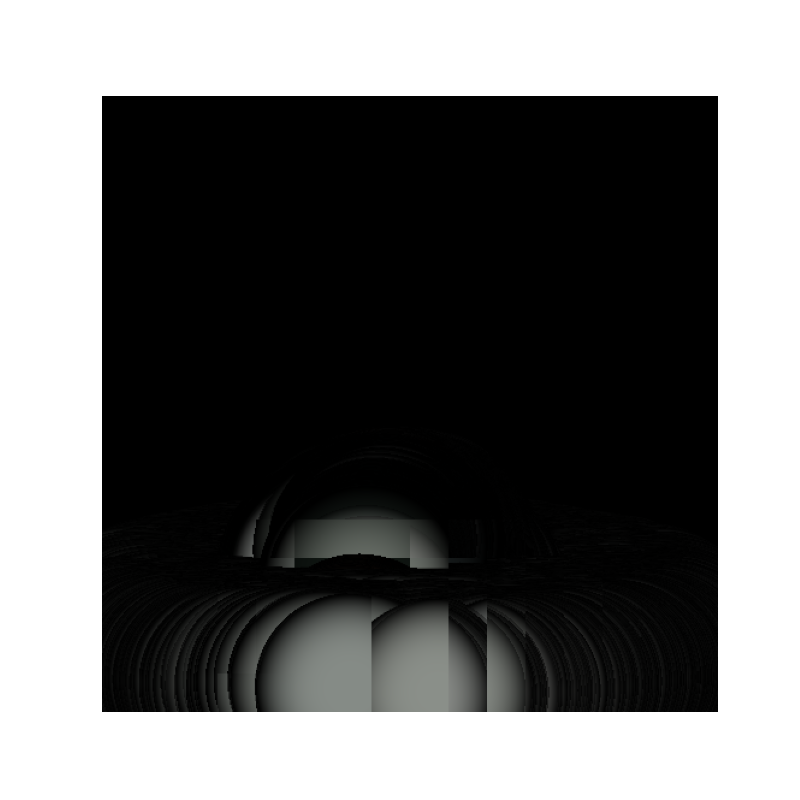

In [38]:
# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "PittsburghBridge/pointcloud.npz")

# Load point cloud
pointcloud = np.load(obj_filename)
verts = torch.Tensor(pointcloud['verts']).to(device)
        
rgb = torch.Tensor(pointcloud['rgb']).to(device)

point_cloud = Pointclouds(points=[verts], features=[rgb])
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");